### Code to preprocess, clean and export the data into database table - tbl_pbr_data

In [71]:
import numpy as np
import pandas as pd
import os
import re
from datetime import date
import sqlalchemy
import matplotlib.pyplot as plt
import sys
import mariadb
import pymysql

import warnings    # to avoid warning during executions
warnings.filterwarnings("ignore")

### Listing PBR files & Set file Name

In [3]:
# load all the file names into a list (files in the pbr data folder)
os.getcwd()
_dir_path = '../../../dataExport/PBRdata'
raw_data = os.listdir(_dir_path)
raw_data

['_10_FPC23_Rhosa.csv',
 '_11_FPC24_SkeMa_1.csv',
 '_12_FPC24_SkeMa_2.csv',
 '_13_FPC11_Rhosa_1.csv',
 '_14_FPC12_DiaLut.csv',
 '_15_FPC22_Thalaps.csv',
 '_16_FPC23_NaCho.csv',
 '_1_FPC13_ChCal_1.csv',
 '_2_FPC13_ChCal_2.csv',
 '_3_FPC13_ThalaPs.csv',
 '_4_FPC14_chamu.csv',
 '_5_FPC14_RhoSa.csv',
 '_6_FPC14_thalaps.csv',
 '_7_FPC21_chamu.csv',
 '_8_FPC21_Techu.csv',
 '_9_FPC22_DiaLut.csv']

In [4]:
filename = raw_data[0]
filename

'_10_FPC23_Rhosa.csv'

### Import Unit number and Species ID from from Database

In [5]:
# database connection with mariaDB for read the read and write data from and to dataframe <----> mariaDB tables
database_username = 'root'
database_password = 'password'
database_ip       = '127.0.0.1:3306'
database_name     = 'data_dashboard'
database_connection = sqlalchemy.create_engine('mariadb+mariadbconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name))

In [6]:
# fetch data from tbl_pbr_lookup to data frame
tbl_lookup = pd.read_sql('SELECT * FROM tbl_pbr_lookup', database_connection)
tbl_lookup.tail(3)

,instance,unit,species,start_date,end_date,remark,raw_file_name
9,10,5,7,1616427000,1626690600,None,_10_FPC23_Rhosa.csv
10,11,7,8,1620129600,1633964395,None,_11_FPC24_SkeMa_1.csv
11,12,7,8,1635246000,1641567595,None,_12_FPC24_SkeMa_2.csv


### Set - Trial No, Unit ID and Species id

In [7]:
species_row = tbl_lookup.query('raw_file_name == @filename')
species_id = int(species_row['species'])
trial_no = int(species_row['instance'])
unit_id = int(species_row['unit'])
species_row

,instance,unit,species,start_date,end_date,remark,raw_file_name
9,10,5,7,1616427000,1626690600,None,_10_FPC23_Rhosa.csv


In [8]:
print("Species ID : ", species_id)
print("Instance No : ", trial_no)
print("Unit No : ", unit_id)

Species ID :  7
Instance No :  10
Unit No :  5


### Load the raw data into a dataframe

In [9]:
# join file name with path - file name can be specified as list item based on required file name
file_path=  os.path.join(_dir_path, filename)

In [47]:
# load the selected file into the data frame.
pbr_rawDF = pd.read_csv(file_path, sep=',')
pbr_rawDF.head(5)

,primary_key,_timeString,FPC23,FT1,FT2,PT1_V4,PT2,FT3,CO2in,CO2_V2,...,QT,QC,QB,QR,QG,QT_corr,TT0,TT1,pH,C_PAR
0,1616427000,2021-3-22 16:30:0,FPC23,6.2414,19.5991,98.8617,136.6463,0.0,0.04,0.1343,...,69.0354,29.563,11.364,6.7134,10.4412,432.2674,21.4094,20.6272,14.803,0.0
1,1616427005,2021-3-22 16:30:5,FPC23,0.0,19.5991,98.9197,136.6463,0.0,0.04,0.1343,...,69.0192,29.5248,11.3483,6.7065,10.4248,432.2674,21.4042,20.6202,14.8002,0.0
2,1616427010,2021-3-22 16:30:10,FPC23,8.4852,19.5818,98.8602,136.5891,0.0,0.04,0.1343,...,69.0068,29.4984,11.3384,6.7015,10.414,432.2674,21.4102,20.5971,14.7837,0.0
3,1616427015,2021-3-22 16:30:15,FPC23,11.2677,19.5982,98.786,136.5615,0.0,0.04,0.1343,...,69.0068,29.4843,11.3325,6.6975,10.4083,432.2674,21.4102,20.5999,14.7966,0.0
4,1616427020,2021-3-22 16:30:20,FPC23,11.4072,19.5787,98.8449,136.4703,0.0,0.04,0.1343,...,68.9968,29.4769,11.3294,6.6953,10.4053,432.2674,21.4136,20.6341,14.7997,0.0


In [11]:
pbr_raw_tmp1 = pbr_rawDF.copy()

#### Data preprocessing function (chain programming)

In [125]:
def pbr_preProcess(pbr_rawDF):
    pbr_raw_tmp1 = pbr_rawDF.copy()
    pbr_raw_tmp1.insert(loc=0, column='trial_no', value=trial_no)
    pbr_raw_tmp1.insert(loc=4, column='species', value=species_id)      
    return(
    pbr_raw_tmp1
    #.assign(trial_no = trail_no)
    .rename(columns={ pbr_raw_tmp1.columns[3]: "unit" })
    .assign(unit = unit_id)
    .replace('Empty', pd.np.nan)
    .replace('inf', pd.np.nan)
    .replace([np.inf, -np.inf], np.nan)
    .astype({'primary_key':'int64', '_timeString':'datetime64[ns]','unit': 'int16','FT1':'float32', 'FT2':'float32', 'PT1_V4':'float32', 'PT2':'float32', 'FT3':'float32', 'CO2in':'float32', 'CO2_V2':'float32', 'CO2sys':'float32', 'LT1':'float32', 'LReactor':'float32', 'C_g':'float32', 'C_Eff':'float32', 'C_CD':'float32', 'T_CD':'float32', 'C_D_g':'float32', 'C_D_Eff':'float32', 'QT':'float32', 'QC':'float32', 'QB':'float32', 'QR':'float32', 'QG':'float32', 'QT_corr':'float32', 'TT0':'float32', 'TT1':'float32', 'pH':'float32', 'C_PAR':'float32'})
    )
    #.astype({'primary_key':'int64', '_timeString':'datetime64[ns]','unit': 'int16','FT1':'float32', 'FT2':'float32', 'PT1_V4':'float32', 'PT2':'float32', 'FT3':'float32', 'CO2in':'float32', 'CO2_V2':'float32', 'CO2sys':'float32', 'LT1':'float32', 'LReactor':'float32', 'C_g':'float32', 'C_Eff':'float32', 'C_CD':'float32', 'T_CD':'float32', 'C_D_g':'float32', 'C_D_Eff':'float32', 'QT':'float32', 'QC':'float32', 'QB':'float32', 'QR':'float32', 'QG':'float32', 'QT_corr':'float32', 'TT0':'float32', 'TT1':'float32', 'pH':'float32', 'C_PAR':'float32'})

pbr_cleaned = pbr_preProcess(pbr_rawDF)

### DATA Checking

In [126]:
count = np.isinf(pbr_cleaned).values.sum()
count

0

In [127]:
'''
Code to check the missing values
'''
# pbr_cleaned_tmp['QC'].value_counts(dropna= False).head(50)

# nul_data = pd.isnull(pbr_cleaned['C_D_g'])
# pbr_cleaned[nul_data].head(5)

pbr_cleaned.isna().sum()

trial_no            0
primary_key         0
_timeString         0
unit                0
species             0
FT1             91151
FT2             91148
PT1_V4           4818
PT2             91146
FT3             91140
CO2in            9207
CO2_V2           4819
CO2sys           9204
LT1              9209
LReactor         4807
C_g              9209
C_Eff            9209
C_CD             4808
T_CD             4807
C_D_g          106425
C_D_Eff        104115
QT              91155
QC              91241
QB              91255
QR              91173
QG              91239
QT_corr          4807
TT0             91145
TT1             91148
pH              91140
C_PAR            4811
dtype: int64

In [88]:
'''
Code for checking the infinity values -- it s all possible code to get information on infinity value
'''

# pbr_cleaned.isin([np.inf]).sum(axis=0)
# pbr_cleaned.index[np.isinf(pbr_cleaned).any(1)]
# pbr_cleaned['C_D_g'].iloc[840999:841010]
# pbr_cleaned_tmp.isin([np.inf, -np.inf]).values.sum()

# count = np.isinf(pbr_cleaned_tmp).values.sum()
# count

# print("printing column name where infinity is present")
# col_name = pbr_cleaned_tmp.columns.to_series()[np.isinf(pbr_cleaned_tmp).any()]
# print(col_name)

# counting infinity in a particular column name
# c = np.isinf(pbr_cleaned_tmp['C_D_g']).values.sum()

# counting infinity in a particular column name
# c = np.isinf(pbr_cleaned_tmp['C_D_Eff']).values.sum()

# r = pbr_cleaned_tmp.index[np.isinf(pbr_cleaned_tmp).any(1)]

# pbr_cleaned_tmp['C_D_Eff'].iloc[391940:391949]

# pbr_cleaned_tmp['C_D_Eff'].value_counts(bins=5)
# pbr_cleaned_tmp.isin([np.inf]).sum(axis=0)


'\nCode for checking the infinity values -- it s all possible code to get information on infinity value\n'

In [128]:
pbr_cleaned_indexed = pbr_cleaned.set_index('_timeString')
pbr_cleaned_indexed.head()

,trial_no,primary_key,unit,species,FT1,FT2,PT1_V4,PT2,FT3,CO2in,...,QT,QC,QB,QR,QG,QT_corr,TT0,TT1,pH,C_PAR
_timeString,,,,,,,,,,,,,,,,,,,,,
2021-03-22 16:30:00,10,1616427000,5,7,6.2414,19.599100,98.861702,136.646301,0.0,0.04,...,69.035400,29.563000,11.3640,6.7134,10.4412,432.267395,21.409401,20.627199,14.8030,0.0
2021-03-22 16:30:05,10,1616427005,5,7,0.0000,19.599100,98.919701,136.646301,0.0,0.04,...,69.019203,29.524799,11.3483,6.7065,10.4248,432.267395,21.404200,20.620199,14.8002,0.0
2021-03-22 16:30:10,10,1616427010,5,7,8.4852,19.581800,98.860199,136.589096,0.0,0.04,...,69.006798,29.498400,11.3384,6.7015,10.4140,432.267395,21.410200,20.597099,14.7837,0.0
2021-03-22 16:30:15,10,1616427015,5,7,11.2677,19.598200,98.786003,136.561493,0.0,0.04,...,69.006798,29.484301,11.3325,6.6975,10.4083,432.267395,21.410200,20.599899,14.7966,0.0
2021-03-22 16:30:20,10,1616427020,5,7,11.4072,19.578699,98.844902,136.470306,0.0,0.04,...,68.996803,29.476900,11.3294,6.6953,10.4053,432.267395,21.413601,20.634100,14.7997,0.0


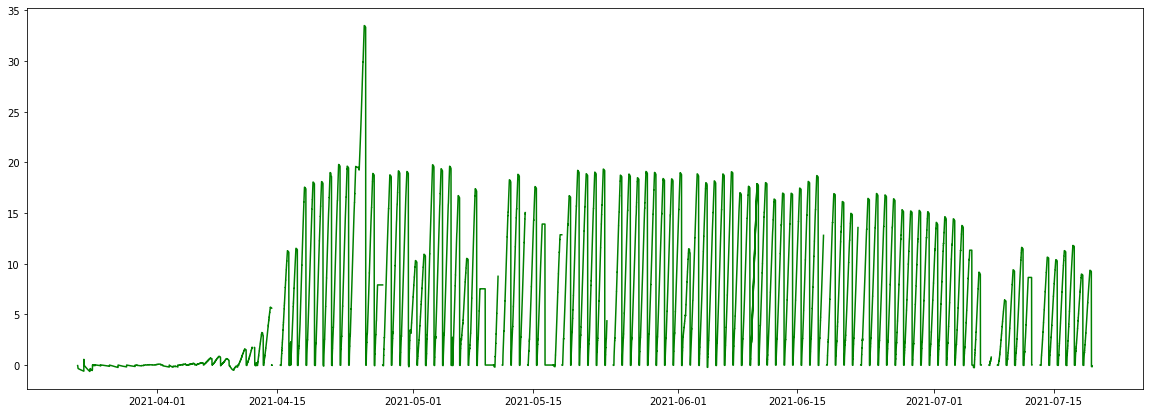

In [129]:
# set the size of our plot
plt.rcParams['figure.figsize']=(20,7)
# plots our series
plt.plot(pbr_cleaned_indexed['C_D_g'], color='green')
# adds title to our time series plot
#plt.title('Customers visted shop since 1950') 
# print the plot
plt.show()


### Missing Value imputations

In [133]:
dataset = pbr_cleaned_indexed.copy()


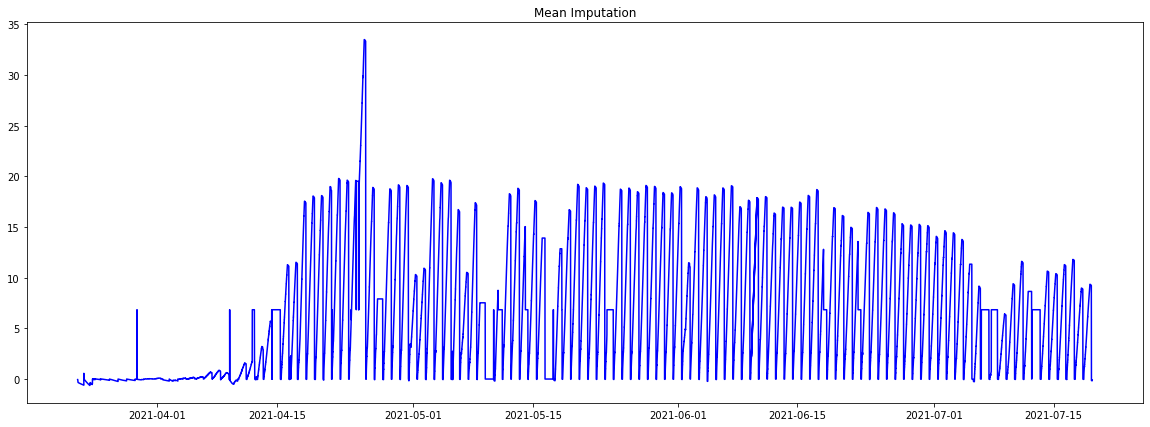

In [134]:
# declare the size of the  plot
plt.rcParams['figure.figsize']=(20,7)
# fill the missing data using the mean of the present observations
dataset = dataset.assign(FillMean=dataset.C_D_g.fillna(dataset.C_D_g.mean()))
# pass the data and declared the colour of your curve, i.e., blue
plt.plot(dataset['FillMean'], color='blue')
# add tittle to the plot
plt.title('Mean Imputation')
 # print the plot
plt.show()

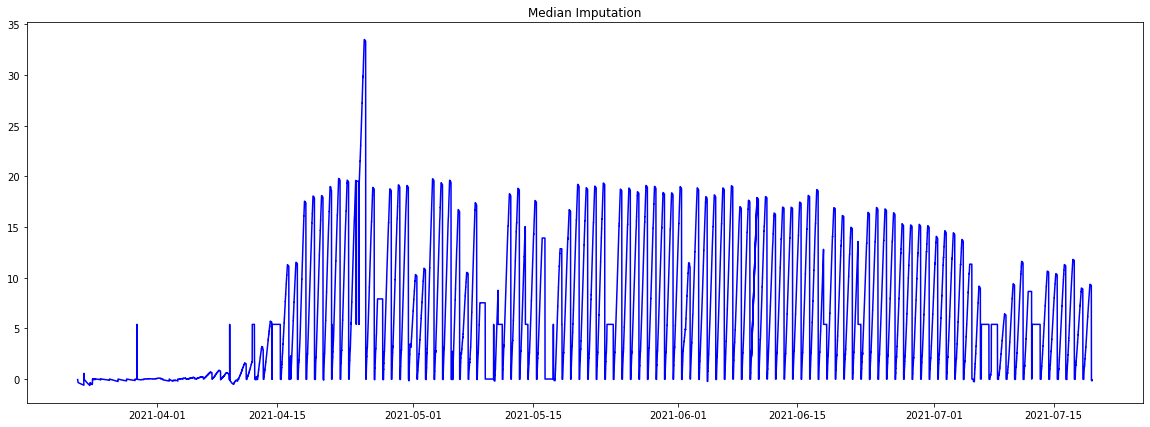

In [135]:
# declare the size of the  plot
plt.rcParams['figure.figsize']=(20,7)
# fill the missing data using the of the present observations
dataset = dataset.assign(Fillmedian=dataset.C_D_g.fillna(dataset.C_D_g.median()))
# pass the data and declared the colouyr opf our curve as blue
plt.plot(dataset['Fillmedian'], color='blue')
# add tittle to the plot
plt.title('Median Imputation')
 # print the plot
plt.show()

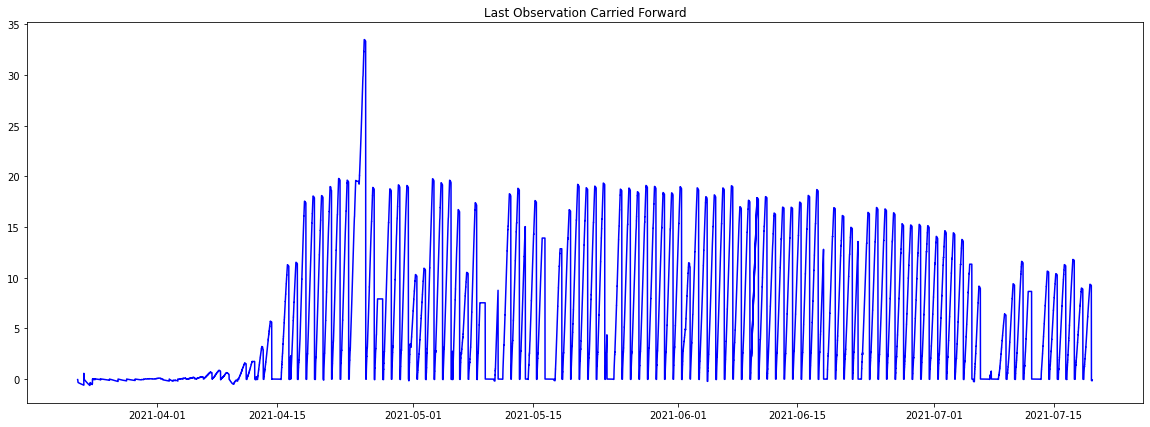

In [136]:
# figure size
plt.rcParams['figure.figsize']=(20,7)
# On the customer column of our data, impute the missing values with the LOCF
dataset['C_D_g_locf']= dataset['C_D_g'].fillna(method ='bfill')
# plot our time series with imputed values
plt.plot(dataset['C_D_g_locf'], color='blue')
#Plot tittle
plt.title('Last Observation Carried Forward')
# show the plot
plt.show()

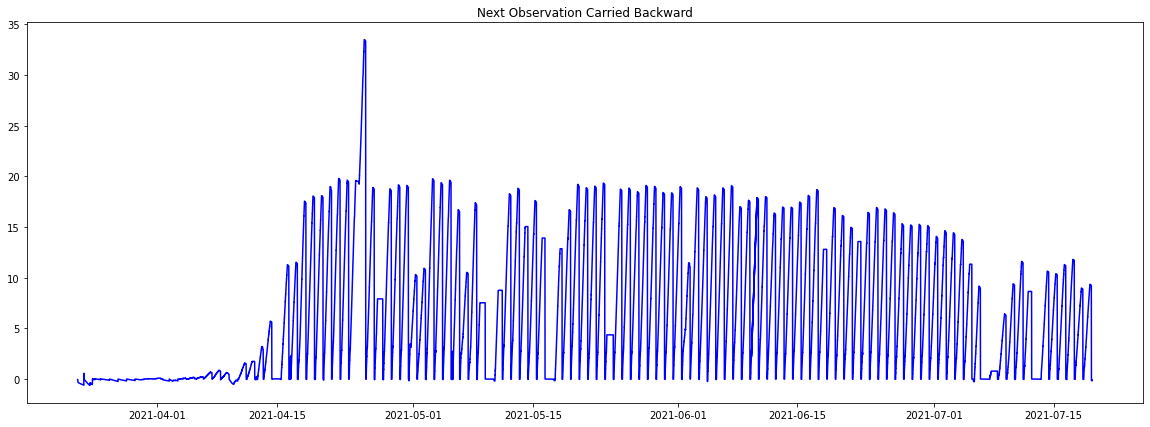

In [137]:
# ffigure size
plt.rcParams['figure.figsize']=(20,7)
# On the customer column of our data, impute the missing values with the LOCF
dataset['C_D_g_nocb']= dataset['C_D_g'].fillna(method ='ffill')
# plot our time series with imputed values
plt.plot(dataset['C_D_g_nocb'], color='blue')
#Plot tittle
plt.title('Next Observation Carried Backward')
# show the plot
plt.show()

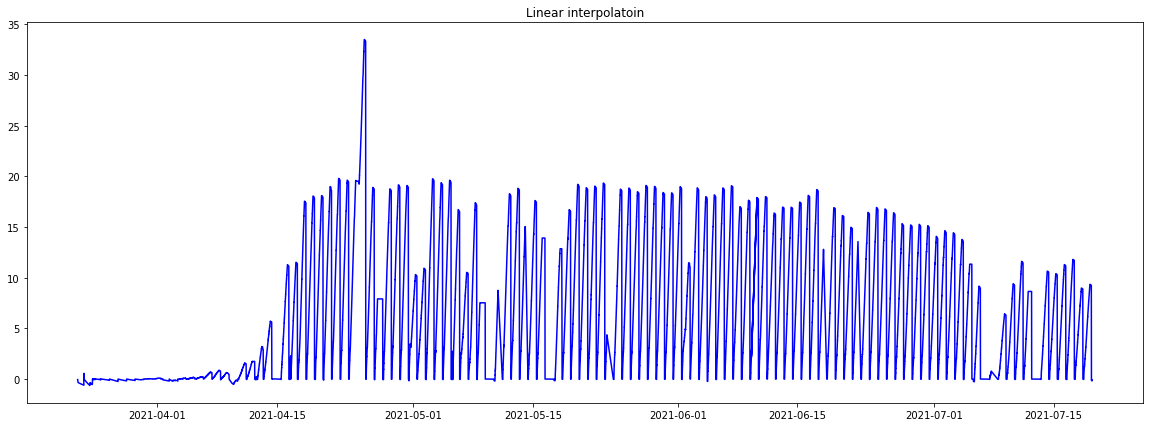

In [138]:
# setting the plot size
plt.rcParams['figure.figsize']=(20,7)
# on our data, impute the missing values using rolling window method
dataset['C_D_g_L']= dataset['C_D_g'].interpolate(method='linear')
# plot the complete dataset
plt.plot(dataset['C_D_g_L'], color='blue')
# add the tittle of our plot as Linear interpolation
plt.title('Linear interpolatoin')
# print the plot
plt.show()

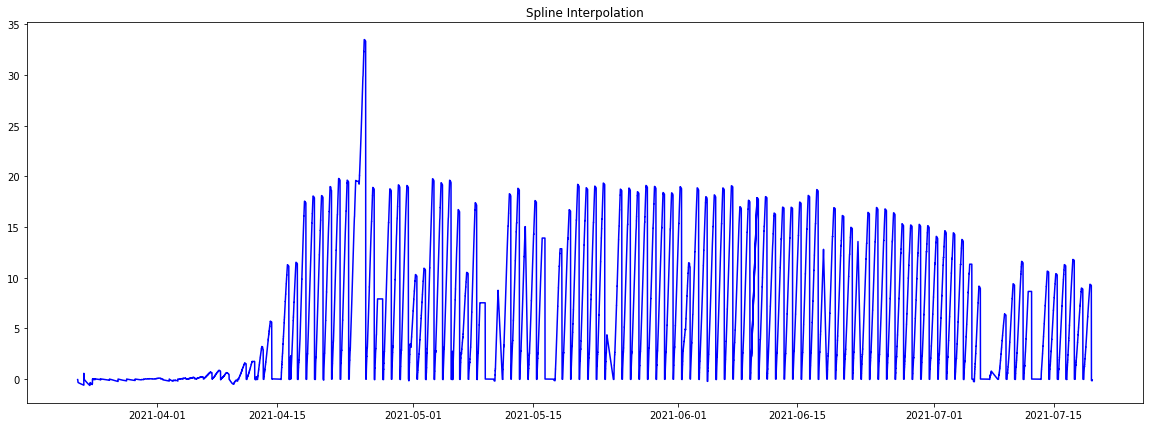

In [139]:
# setting the plot size
plt.rcParams['figure.figsize']=(20,7)
# on our data, impute the missing values using the interpolation techniques and specifically, the lineare method
dataset['C_D_g_Spline']= dataset['C_D_g'].interpolate(option='spline')
# plot the complete dataset
plt.plot(dataset['C_D_g_Spline'], color='blue')
# add the tittle of our plot as Linear interpolation
plt.title('Spline Interpolation')
# print the plot
plt.show()

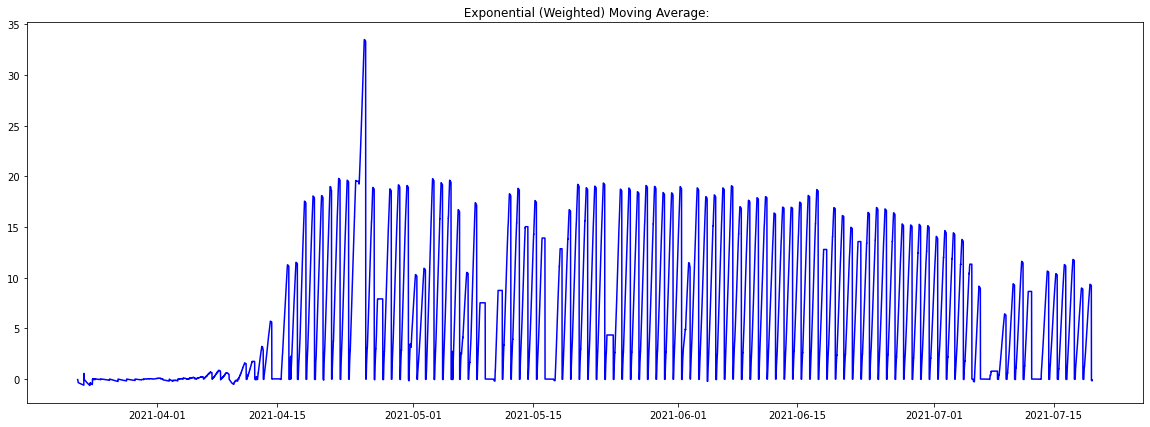

In [144]:
# ffigure size
plt.rcParams['figure.figsize']=(20,7)
# On the customer column of our data, impute the missing values with the LOCF
dataset['SMA']= dataset['C_D_g'].ewm(halflife=4).mean()
# plot our time series with imputed values
plt.plot(dataset['SMA'], color='blue')
#Plot tittle
plt.title(' Exponential (Weighted) Moving Average:')
# show the plot
plt.show()

In [145]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2052721 entries, 2021-03-22 16:30:00 to 2021-07-19 12:30:00
Data columns (total 37 columns):
 #   Column        Dtype  
---  ------        -----  
 0   trial_no      int64  
 1   primary_key   int64  
 2   unit          int16  
 3   species       int64  
 4   FT1           float32
 5   FT2           float32
 6   PT1_V4        float32
 7   PT2           float32
 8   FT3           float32
 9   CO2in         float32
 10  CO2_V2        float32
 11  CO2sys        float32
 12  LT1           float32
 13  LReactor      float32
 14  C_g           float32
 15  C_Eff         float32
 16  C_CD          float32
 17  T_CD          float32
 18  C_D_g         float32
 19  C_D_Eff       float32
 20  QT            float32
 21  QC            float32
 22  QB            float32
 23  QR            float32
 24  QG            float32
 25  QT_corr       float32
 26  TT0           float32
 27  TT1           float32
 28  pH            float32
 29  C_PAR       

In [17]:
pbr_cleaned_tmp= pbr_cleaned.copy()
pbr_columns = ['FT1', 'FT2', 'PT1_V4', 'PT2', 'FT3', 'CO2in', 'CO2_V2', 'CO2sys', 'LT1', 'LReactor', 'C_g', 'C_Eff', 'C_CD', 'T_CD', 'C_D_g', 'C_D_Eff', 'QT', 'QC', 'QB', 'QR', 'QG', 'QT_corr', 'TT0', 'TT1', 'pH', 'C_PAR']

In [146]:
for pbr_col in pbr_columns:
    pbr_cleaned_indexed[pbr_col]=pbr_cleaned_indexed[pbr_col].interpolate(option='spline')


### Missing value Visualization

In [1]:
# Package imports
import seaborn as sns
import pandas as pd
import missingno as msno
%matplotlib inline

In [147]:
pbr_datamissing = pbr_cleaned_indexed.copy()

<AxesSubplot:>

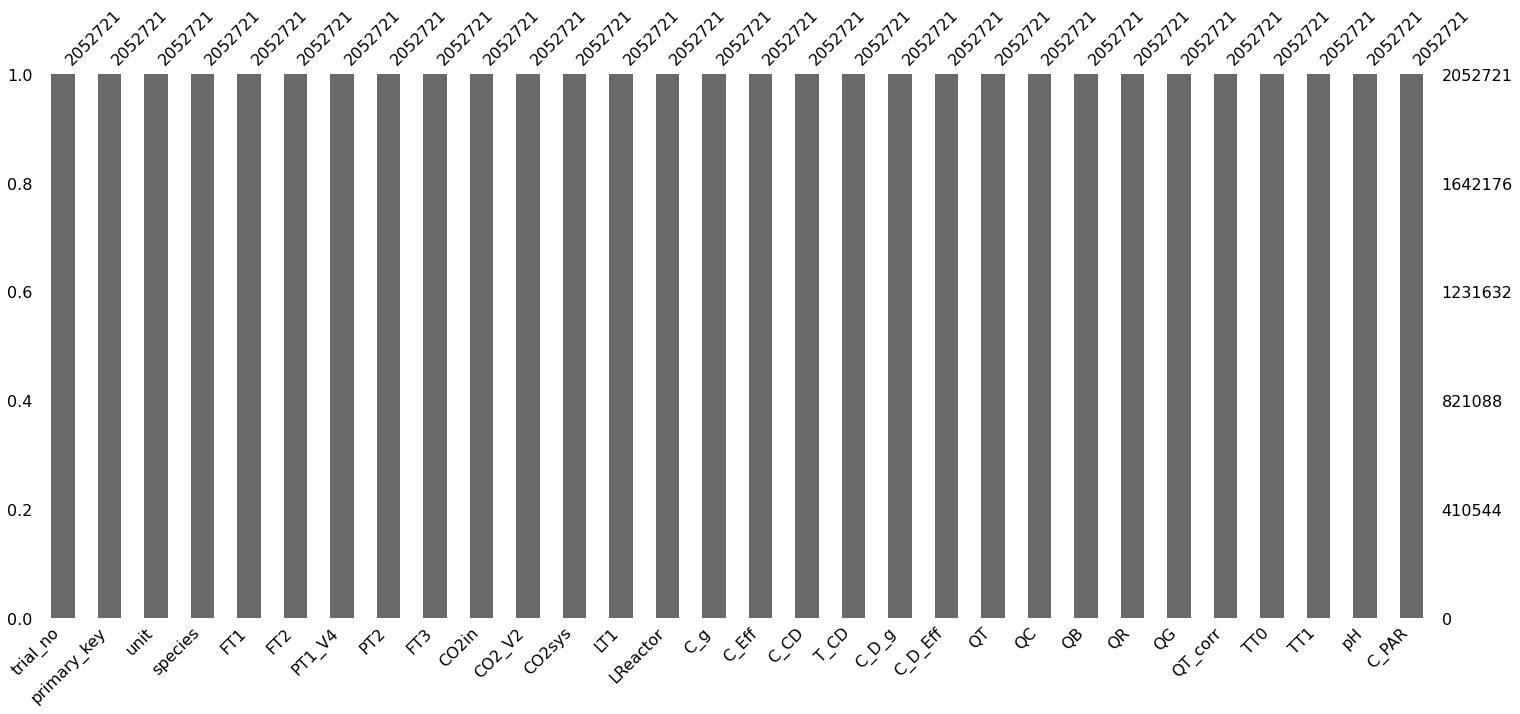

In [148]:
msno.bar(pbr_datamissing)

<AxesSubplot:>

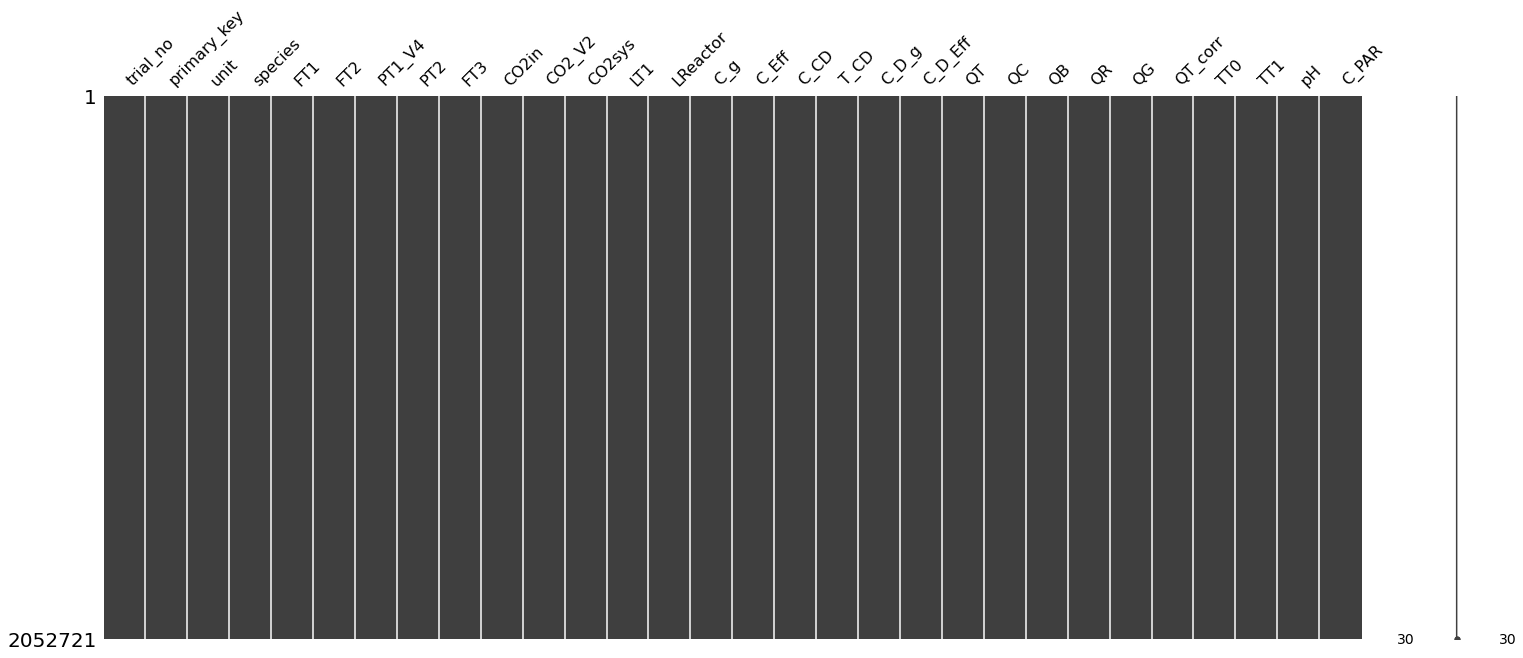

In [149]:
msno.matrix(pbr_datamissing)

<AxesSubplot:>

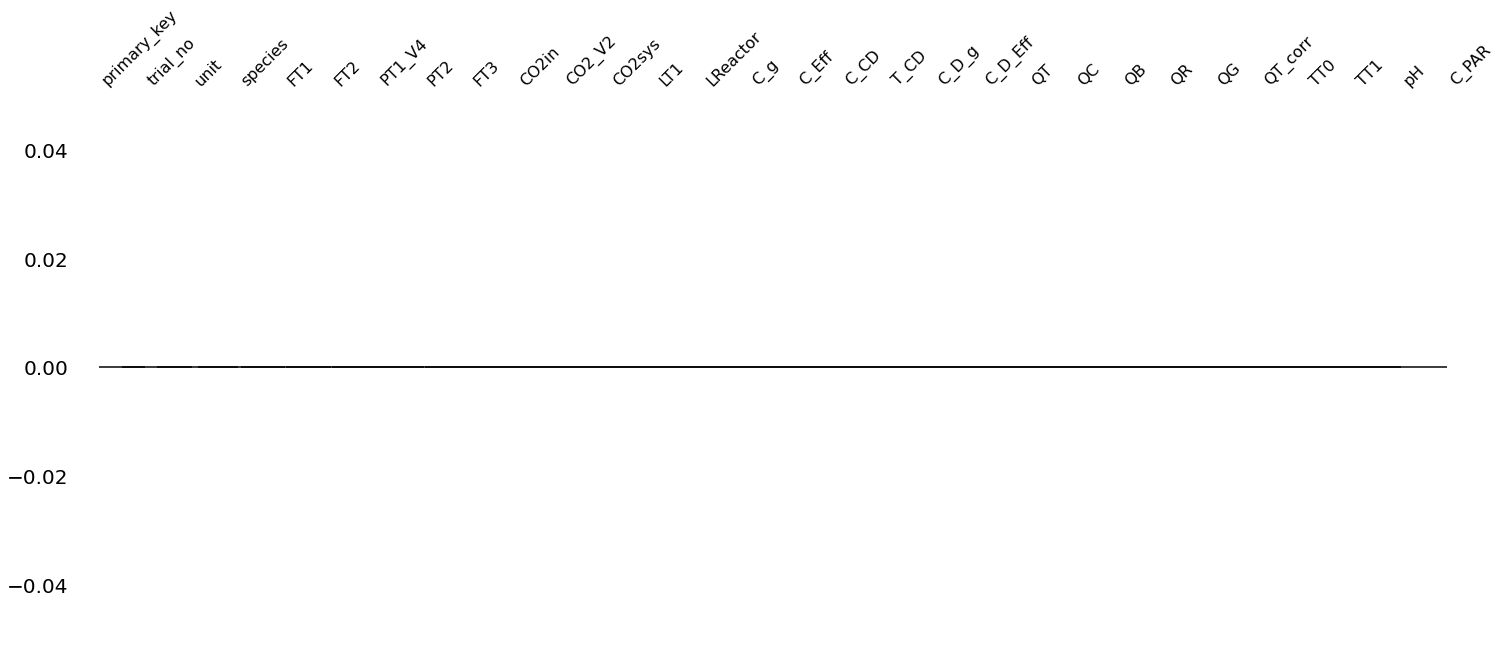

In [150]:
msno.dendrogram(pbr_datamissing)

<AxesSubplot:>

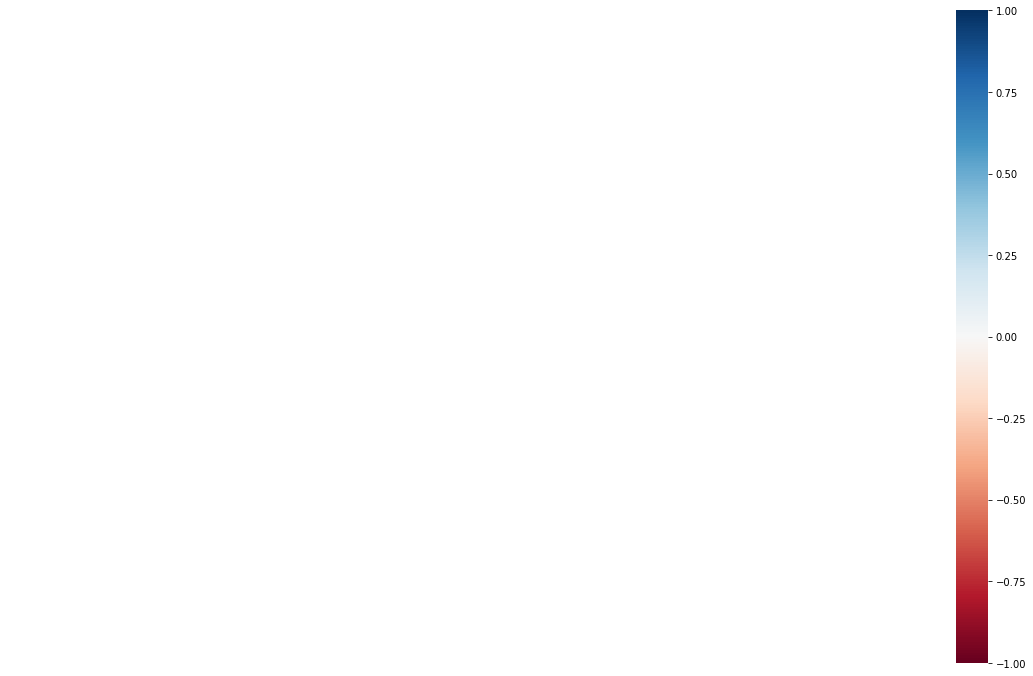

In [151]:
msno.heatmap(pbr_datamissing)

### Export Cleaned Data into DB

In [163]:
pbr_cleaned_indexed.head()

,trial_no,primary_key,unit,species,FT1,FT2,PT1_V4,PT2,FT3,CO2in,...,QT,QC,QB,QR,QG,QT_corr,TT0,TT1,pH,C_PAR
_timeString,,,,,,,,,,,,,,,,,,,,,
2021-03-22 16:30:00,10,1616427000,5,7,6.2414,19.599100,98.861702,136.646301,0.0,0.04,...,69.035400,29.563000,11.3640,6.7134,10.4412,432.267395,21.409401,20.627199,14.8030,0.0
2021-03-22 16:30:05,10,1616427005,5,7,0.0000,19.599100,98.919701,136.646301,0.0,0.04,...,69.019203,29.524799,11.3483,6.7065,10.4248,432.267395,21.404200,20.620199,14.8002,0.0
2021-03-22 16:30:10,10,1616427010,5,7,8.4852,19.581800,98.860199,136.589096,0.0,0.04,...,69.006798,29.498400,11.3384,6.7015,10.4140,432.267395,21.410200,20.597099,14.7837,0.0
2021-03-22 16:30:15,10,1616427015,5,7,11.2677,19.598200,98.786003,136.561493,0.0,0.04,...,69.006798,29.484301,11.3325,6.6975,10.4083,432.267395,21.410200,20.599899,14.7966,0.0
2021-03-22 16:30:20,10,1616427020,5,7,11.4072,19.578699,98.844902,136.470306,0.0,0.04,...,68.996803,29.476900,11.3294,6.6953,10.4053,432.267395,21.413601,20.634100,14.7997,0.0


In [164]:
pbr_cleaned_indexed = pbr_cleaned_indexed.reset_index(level=0)

In [165]:
pbr_cleaned_indexed.head()

,_timeString,trial_no,primary_key,unit,species,FT1,FT2,PT1_V4,PT2,FT3,...,QT,QC,QB,QR,QG,QT_corr,TT0,TT1,pH,C_PAR
0,2021-03-22 16:30:00,10,1616427000,5,7,6.2414,19.599100,98.861702,136.646301,0.0,...,69.035400,29.563000,11.3640,6.7134,10.4412,432.267395,21.409401,20.627199,14.8030,0.0
1,2021-03-22 16:30:05,10,1616427005,5,7,0.0000,19.599100,98.919701,136.646301,0.0,...,69.019203,29.524799,11.3483,6.7065,10.4248,432.267395,21.404200,20.620199,14.8002,0.0
2,2021-03-22 16:30:10,10,1616427010,5,7,8.4852,19.581800,98.860199,136.589096,0.0,...,69.006798,29.498400,11.3384,6.7015,10.4140,432.267395,21.410200,20.597099,14.7837,0.0
3,2021-03-22 16:30:15,10,1616427015,5,7,11.2677,19.598200,98.786003,136.561493,0.0,...,69.006798,29.484301,11.3325,6.6975,10.4083,432.267395,21.410200,20.599899,14.7966,0.0
4,2021-03-22 16:30:20,10,1616427020,5,7,11.4072,19.578699,98.844902,136.470306,0.0,...,68.996803,29.476900,11.3294,6.6953,10.4053,432.267395,21.413601,20.634100,14.7997,0.0


In [170]:
new_col = list(pbr_cleaned.columns)
pbr_cleaned_indexed=pbr_cleaned_indexed[new_col]

In [171]:
pbr_cleaned_indexed.head()

,trial_no,primary_key,_timeString,unit,species,FT1,FT2,PT1_V4,PT2,FT3,...,QT,QC,QB,QR,QG,QT_corr,TT0,TT1,pH,C_PAR
0,10,1616427000,2021-03-22 16:30:00,5,7,6.2414,19.599100,98.861702,136.646301,0.0,...,69.035400,29.563000,11.3640,6.7134,10.4412,432.267395,21.409401,20.627199,14.8030,0.0
1,10,1616427005,2021-03-22 16:30:05,5,7,0.0000,19.599100,98.919701,136.646301,0.0,...,69.019203,29.524799,11.3483,6.7065,10.4248,432.267395,21.404200,20.620199,14.8002,0.0
2,10,1616427010,2021-03-22 16:30:10,5,7,8.4852,19.581800,98.860199,136.589096,0.0,...,69.006798,29.498400,11.3384,6.7015,10.4140,432.267395,21.410200,20.597099,14.7837,0.0
3,10,1616427015,2021-03-22 16:30:15,5,7,11.2677,19.598200,98.786003,136.561493,0.0,...,69.006798,29.484301,11.3325,6.6975,10.4083,432.267395,21.410200,20.599899,14.7966,0.0
4,10,1616427020,2021-03-22 16:30:20,5,7,11.4072,19.578699,98.844902,136.470306,0.0,...,68.996803,29.476900,11.3294,6.6953,10.4053,432.267395,21.413601,20.634100,14.7997,0.0


In [ ]:


#or
#df=df.reindex(columns=new_cols)
# print(df)

In [172]:
connection = pymysql.connect(host='localhost',
                            user='root',
                            password='password',
                            db='data_dashboard')

# create cursor
cursor=connection.cursor()

In [173]:
cols = "`,`".join([str(i) for i in pbr_cleaned.columns.tolist()])

In [174]:
for i,row in pbr_cleaned_indexed.iterrows():
    sql = "INSERT INTO `tbl_pbr_data` (`" +cols + "`) VALUES (" + "%s,"*(len(row)-1) + "%s)"
    cursor.execute(sql, tuple(row))
    # the connection is not autocommitted by default, so we must commit to save our changes
    #connection.commit()

In [175]:
connection.commit()
connection.close()

In [176]:
tbl_logdata = pd.read_sql('SELECT * FROM tbl_pbr_data', database_connection)
tbl_logdata.head(10)

,trial_no,primary_key,_timeString,unit,species,FT1,FT2,PT1_V4,PT2,FT3,...,QT,QC,QB,QR,QG,QT_corr,TT0,TT1,pH,C_PAR
0,10,1616427000,2021-03-22 16:30:00,5,7,6.2414,19.5991,98.8617,136.646,0.0,...,69.0354,29.5630,11.3640,6.7134,10.4412,432.267,21.4094,20.6272,14.8030,0.0
1,10,1616427005,2021-03-22 16:30:05,5,7,0.0000,19.5991,98.9197,136.646,0.0,...,69.0192,29.5248,11.3483,6.7065,10.4248,432.267,21.4042,20.6202,14.8002,0.0
2,10,1616427010,2021-03-22 16:30:10,5,7,8.4852,19.5818,98.8602,136.589,0.0,...,69.0068,29.4984,11.3384,6.7015,10.4140,432.267,21.4102,20.5971,14.7837,0.0
3,10,1616427015,2021-03-22 16:30:15,5,7,11.2677,19.5982,98.7860,136.561,0.0,...,69.0068,29.4843,11.3325,6.6975,10.4083,432.267,21.4102,20.5999,14.7966,0.0
4,10,1616427020,2021-03-22 16:30:20,5,7,11.4072,19.5787,98.8449,136.470,0.0,...,68.9968,29.4769,11.3294,6.6953,10.4053,432.267,21.4136,20.6341,14.7997,0.0
5,10,1616427025,2021-03-22 16:30:25,5,7,10.8601,19.5818,98.8701,136.470,0.0,...,68.9968,29.4729,11.3278,6.6942,10.4037,432.267,21.4136,20.6211,14.7997,0.0
6,10,1616427030,2021-03-22 16:30:30,5,7,9.5855,19.5995,99.0455,136.470,0.0,...,68.9968,29.4729,11.3278,6.6942,10.4037,432.267,21.4136,20.5732,14.7997,0.0
7,10,1616427035,2021-03-22 16:30:35,5,7,7.6704,19.5510,99.2156,137.691,0.0,...,68.9968,29.4697,11.3265,6.6932,10.4024,432.267,21.4136,20.5811,14.7997,0.0
8,10,1616427040,2021-03-22 16:30:40,5,7,3.2004,19.5893,99.5995,137.367,0.0,...,68.9931,29.4691,11.3262,6.6931,10.4021,432.268,21.4068,20.5704,14.7837,0.0
9,10,1616427045,2021-03-22 16:30:45,5,7,3.7583,20.2719,99.3118,138.936,0.0,...,68.9931,29.4691,11.3262,6.6931,10.4077,432.268,21.4131,20.5865,14.7966,0.0


In [177]:
tbl_logdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2052721 entries, 0 to 2052720
Data columns (total 31 columns):
 #   Column       Dtype         
---  ------       -----         
 0   trial_no     int64         
 1   primary_key  int64         
 2   _timeString  datetime64[ns]
 3   unit         int64         
 4   species      int64         
 5   FT1          float64       
 6   FT2          float64       
 7   PT1_V4       float64       
 8   PT2          float64       
 9   FT3          float64       
 10  CO2in        float64       
 11  CO2_V2       float64       
 12  CO2sys       float64       
 13  LT1          float64       
 14  LReactor     float64       
 15  C_g          float64       
 16  C_Eff        float64       
 17  C_CD         float64       
 18  T_CD         float64       
 19  C_D_g        float64       
 20  C_D_Eff      float64       
 21  QT           float64       
 22  QC           float64       
 23  QB           float64       
 24  QR           float64    

## Appendix

In [ ]:
'''
# set instance number from the file name
trail_no = re.split("_", filename)
print(trail_no)
trail_no = int(trail_no[1])
print(trail_no)

'''

In [ ]:
'''
unit_ID = tbl_unit.query('unit_name == "FPC13"')
unit_no = unit_ID['unit_id']
unit_no

'''